In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [6]:
from google.colab import files
uploaded = files.upload()


Saving card_fraud.csv to card_fraud.csv


In [7]:

df = pd.read_csv("card_fraud.csv")
df.head()


print("\n📄 Dataset Info:")
print(df.info())
print("\nDuplicate rows:", df.duplicated().sum())
print("\nMissing values per column:")
print(df.isnull().sum())


📄 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Transaction_ID                    100000 non-null  int64  
 1   User_ID                           100000 non-null  int64  
 2   Transaction_Amount                100000 non-null  int64  
 3   Transaction_Date                  100000 non-null  object 
 4   Transaction_Time                  100000 non-null  object 
 5   Transaction_Location              100000 non-null  object 
 6   Merchant_ID                       100000 non-null  int64  
 7   Device_ID                         100000 non-null  int64  
 8   Card_Type                         100000 non-null  object 
 9   Transaction_Currency              100000 non-null  object 
 10  Transaction_Status                100000 non-null  object 
 11  Previous_Transaction_Count        10

In [8]:
df = df.drop(['Transaction_ID', 'User_ID'], axis=1, errors='ignore')

# Convert date/time
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')
df['Year'] = df['Transaction_Date'].dt.year
df['Month'] = df['Transaction_Date'].dt.month
df['Day'] = df['Transaction_Date'].dt.day
df['Hour'] = pd.to_datetime(df['Transaction_Time'], errors='coerce').dt.hour
df.drop(['Transaction_Date', 'Transaction_Time'], axis=1, inplace=True)

/tmp/ipython-input-879532866.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Transaction_Time'], errors='coerce').dt.hour


In [9]:
cat_cols = [
    'Transaction_Location', 'Merchant_ID', 'Device_ID',
    'Card_Type', 'Transaction_Currency', 'Transaction_Status',
    'Authentication_Method', 'Transaction_Category'
]

le = LabelEncoder()
for col in cat_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))


In [10]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [13]:
print("\n🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


🎯 Accuracy: 0.9998

Confusion Matrix:
 [[10000     0]
 [    4  9996]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



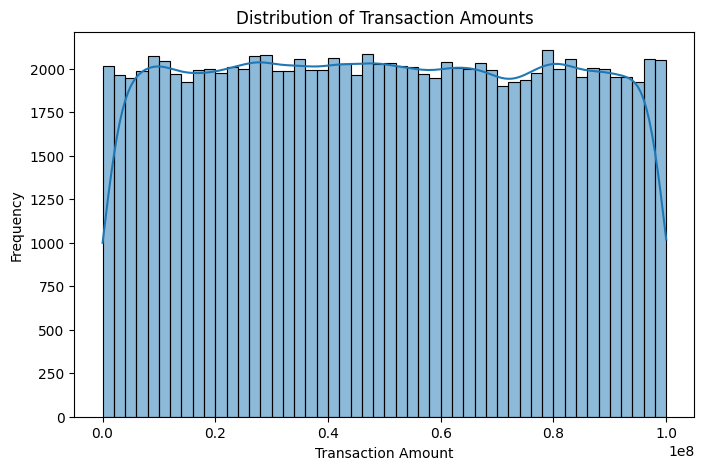

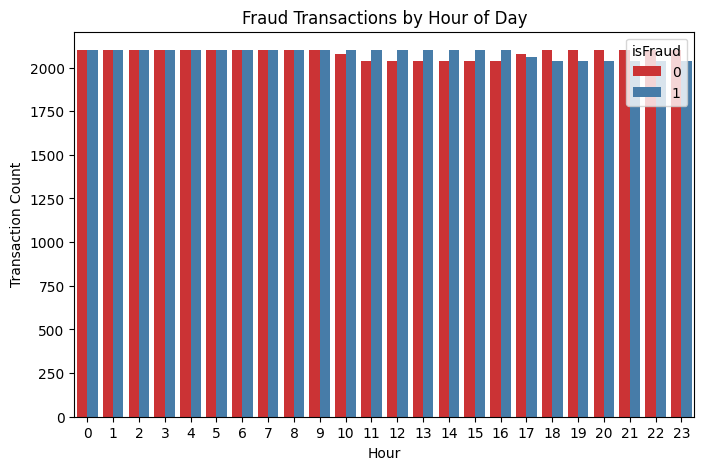

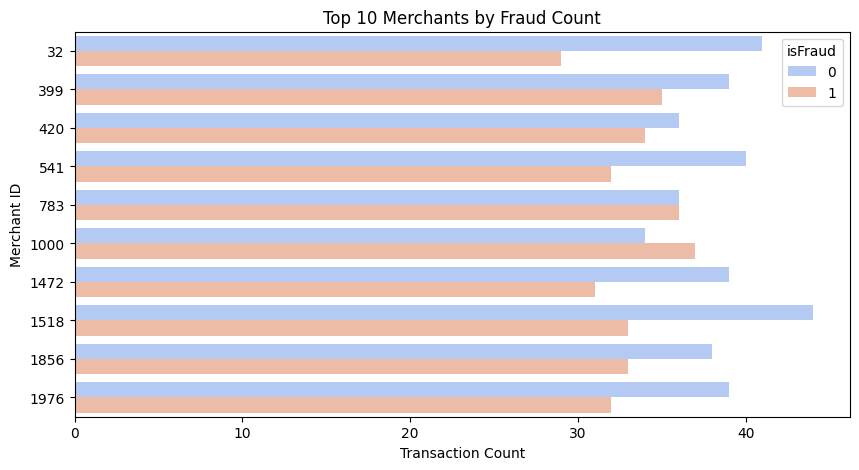

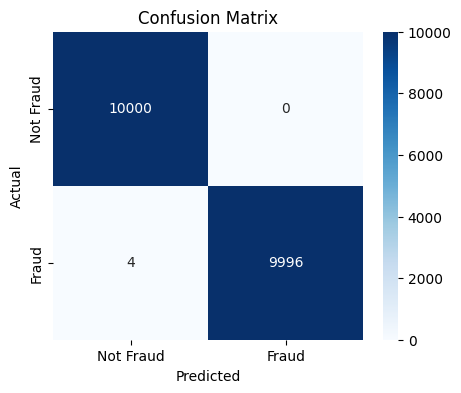

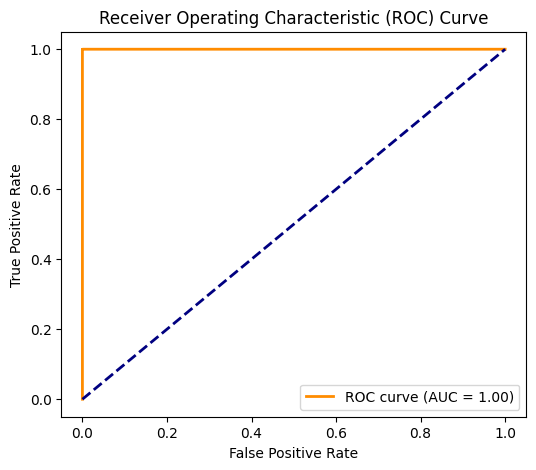

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df['Transaction_Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='Hour', hue='isFraud', data=df, palette='Set1')
plt.title('Fraud Transactions by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
plt.show()

plt.figure(figsize=(10,5))
top_merchants = df['Merchant_ID'].value_counts().head(10).index
sns.countplot(y='Merchant_ID', hue='isFraud', data=df[df['Merchant_ID'].isin(top_merchants)], palette='coolwarm')
plt.title('Top 10 Merchants by Fraud Count')
plt.xlabel('Transaction Count')
plt.ylabel('Merchant ID')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_prob = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [15]:
joblib.dump(model, "fraud_detector.pkl")
joblib.dump(scaler, "scaler.pkl")

print("\n✅ Model and scaler saved successfully as 'fraud_detector.pkl' and 'scaler.pkl'")


✅ Model and scaler saved successfully as 'fraud_detector.pkl' and 'scaler.pkl'
